In [44]:
# %pip install scikit-image

In [14]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

<h4>Reading images & Resizing images</h4>
<p>
<i>read_img</i> function accepts image file path and a new_size parameter to read the image and resize it if the new_size parameter is set.
</p>

In [15]:
def read_img(path, new_size = None):
    if(new_size):
        return cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), \
                          (new_size[0], new_size[1]), interpolation = cv2.INTER_AREA)
    else:
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
org = read_img("imgs/org.png", new_size=(512, 512))
noisy_1 = read_img("imgs/noisy_1.jpg", new_size=(512, 512))
noisy_2 = read_img("imgs/noisy_2.jpg", new_size=(512, 512))
noisy_3 = read_img("imgs/noisy_3.jpg", new_size=(512, 512))

all_images = [("org.png", org), ("noisy_1.jpg", noisy_1), ("noisy_2.jpg", noisy_2), ("noisy_3.jpg", noisy_3)]

<h4>Histograms of each image</h4>
<p>

</p>

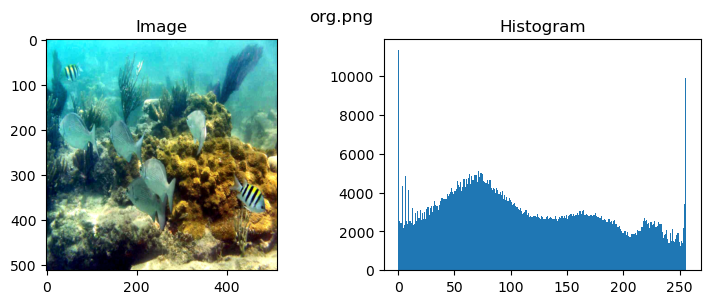

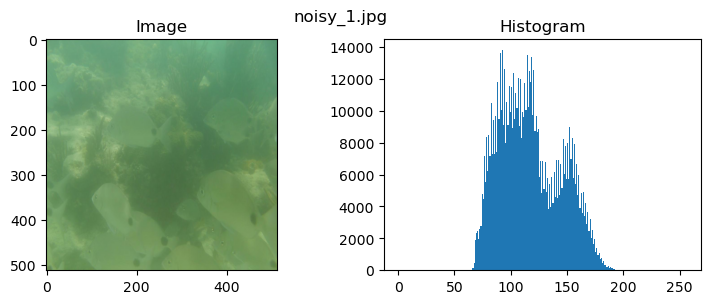

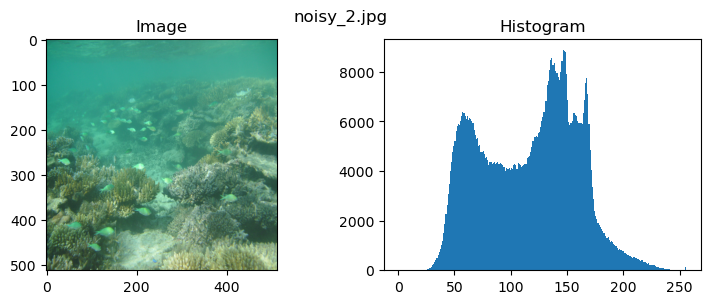

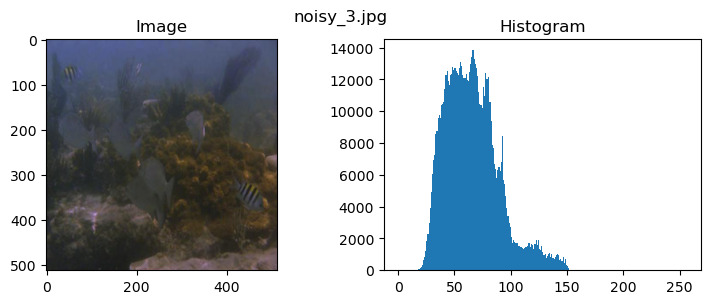

In [16]:
def histogram(img):
    flatten_img = np.ravel(img)
    counts = np.zeros(256)
    for px in flatten_img:
        counts[px] += 1
    # bins = np.array(np.where(counts != 0)).flatten()
    bins = np.arange(0, 257, 1)
    # counts = counts[counts != 0]
    return bins, counts

for img in all_images:
    bins, counts = histogram(img[1])
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))
    fig.suptitle(img[0])
    axs[0].imshow(img[1])
    axs[0].set_title(f"Image")
    axs[1].stairs(counts, bins, fill=True)
    axs[1].set_title(f"Histogram")
    fig.tight_layout
    plt.show()

In [17]:
def cumsum(hist, normalize = False):
    csum = np.zeros(len(hist))
    csum[0] = hist[0]
    for i in range(1, len(hist)):
        csum[i] = csum[i-1] + hist[i]
    return csum/csum[-1] if normalize else csum
    # return np.round(((cdf - min(cdf))/(1 - min(cdf))) * 255)    
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def visualize_org_vs_eq(bins, counts, hu, title, cname):
    # extending ranges to (0, 255)
    counts_cp = np.zeros(256)
    for i in range(256):
        if i in bins:
            searched = np.where(bins == i)
            counts_cp[i] = counts[searched[0]]
        else:
            counts_cp[i] = 0
    counts = counts_cp.astype(int)
    # counts = np.insert(counts, 0, [0]*bins[0])
    # counts = np.append(counts, [1]*(255-bins[-1]))
    # hu = np.insert(hu, 0, [0]*bins[0])
    # hu = np.append(hu, [1]*(255-bins[-1])).astype(int)
    hu_cp = np.zeros(256)
    for i in range(256):
        if i in bins:
            searched = np.where(bins == i)
            hu_cp[i] = hu[searched[0]]
        else:
            hu_cp[i] = 0
    hu = hu_cp.astype(int)

    # Calculating equalizied image histogram
    equalized_hist = np.zeros(256)
    for i in range(256):
        equalized_hist[hu[i]] += counts[i]

    fig, axs = plt.subplots(1, 2, figsize=(9, 3))
    fig.suptitle(title)
    axs[0].stairs(counts, np.arange(0, len(counts) + 1, 1), fill=True)
    axs[0].set_title(f"Original histogram for channel {cname}")
    axs[1].stairs(equalized_hist, np.arange(0, len(equalized_hist) + 1, 1), fill=True)
    axs[1].set_title(f"Equalizied histogram for channel {cname}")
    fig.tight_layout()
    plt.show()

def equalize_hist(img, counts, hu, bins, title=None, cname=None):
    equalized_hist = np.zeros(256)
    equalized_img = img.ravel()
    for i in range(256):
        pixels = np.array(np.where(equalized_img == i)).flatten()
        equalized_img[pixels] = hu[i]
        equalized_hist[hu[i]] += counts[i]

    if(title and cname):
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        fig.suptitle(title)
        axs[0].stairs(counts, bins, fill=True)
        axs[0].set_title(f"Original histogram for channel {cname}")
        axs[1].stairs(equalized_hist, bins, fill=True)
        axs[1].set_title(f"Equalizied histogram for channel {cname}")
        fig.tight_layout()
        plt.show()

    return equalized_img, equalized_hist

def hist_matchings(src, ref, cname=None):
    src_bins, src_counts = histogram(src)
    ref_bins, ref_counts = histogram(ref)

    print(f"Equalizing channel {cname}")
    cdf_src = cumsum(src_counts, normalize=True)
    cdf_ref = cumsum(ref_counts, normalize=True)
    hu_src = np.round(cdf_src * 255).astype(int)
    hu_ref = np.round(cdf_ref * 255).astype(int)
    # hu_src = np.round(((cdf_src - min(cdf_src))/(1 - min(cdf_src))) * 255).astype(int)
    # hu_ref = np.round(((cdf_ref - min(cdf_ref))/(1 - min(cdf_ref))) * 255).astype(int)

    eq_src, src_equalized_hist = equalize_hist(src, src_counts, hu_src, src_bins, "Original image", cname)
    eq_ref, ref_equalized_hist = equalize_hist(ref, ref_counts, hu_ref, ref_bins, "Template image", cname)

    src_flattened = src.ravel()
    # mapping
    mapped_img = np.copy(src_flattened)
    for i in range(256):
        pixels = np.array(np.where(src_flattened == i)).flatten()
        pixel_idx = find_nearest(hu_ref, hu_src[i])
        mapped_img[pixels] = pixel_idx
    return mapped_img.reshape(src.shape)

def hist_match(src, ref, cname=None):
    src_shape = src.shape
    
    src = src.ravel()
    ref = ref.ravel()

    o_values, bin_idx, o_counts = np.unique(src, return_inverse=True, return_counts=True)
    b_values, b_counts = np.unique(ref, return_counts=True)

    print(f"Equalizing channel {cname}")
    o_quantiles = cumsum(o_counts, normalize=True)
    b_quantiles = cumsum(b_counts, normalize=True)
    eq_o = np.round(((o_quantiles - min(o_quantiles))/(1 - min(o_quantiles))) * 255).astype(int)
    eq_b = np.round(((b_quantiles - min(b_quantiles))/(1 - min(b_quantiles))) * 255).astype(int)

    visualize_org_vs_eq(o_values, o_counts, eq_o, "Original image", cname)
    visualize_org_vs_eq(b_values, b_counts, eq_b, "Template image", cname)

    print(f"Starting match process")
    interp_t_values = np.interp(eq_o, eq_b, b_values)
    return interp_t_values[bin_idx].reshape(src_shape)



Matching org.png with noisy_1.jpg:
Matching each channel separately.
R Channel:
Equalizing channel R


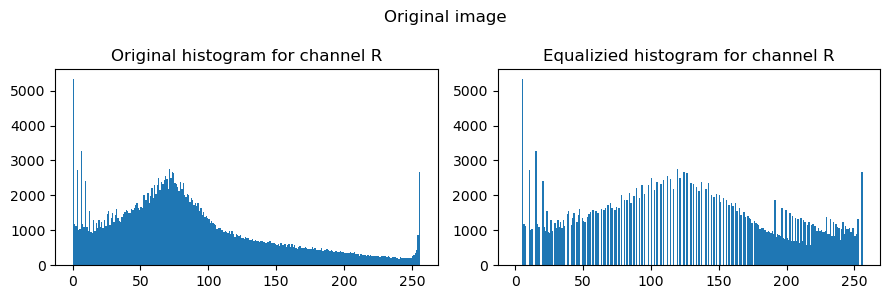

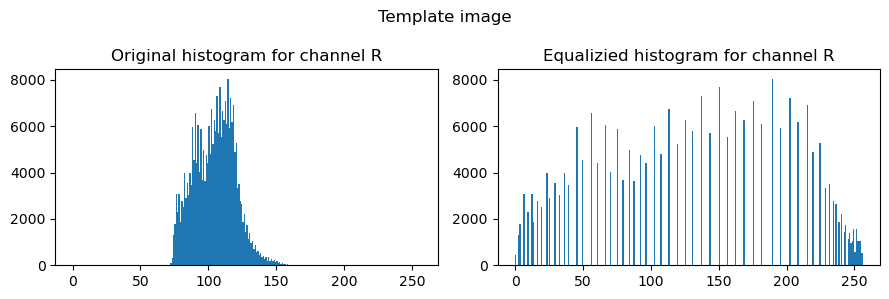

G Channel:
Equalizing channel G


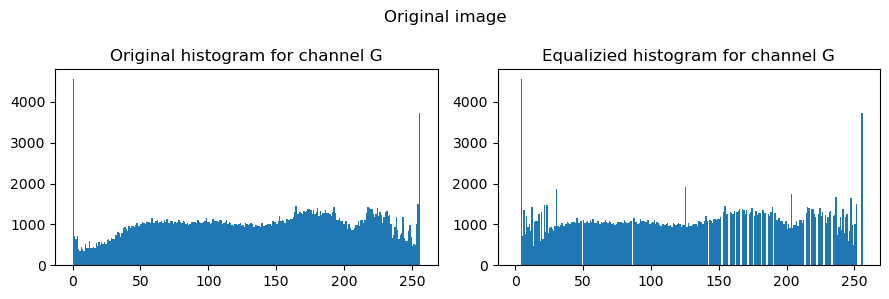

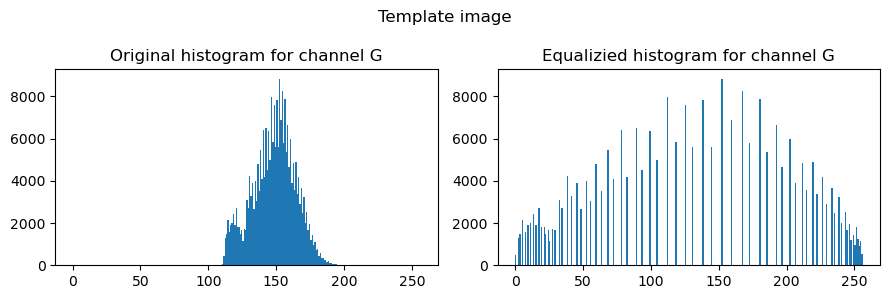

B Channel:
Equalizing channel B


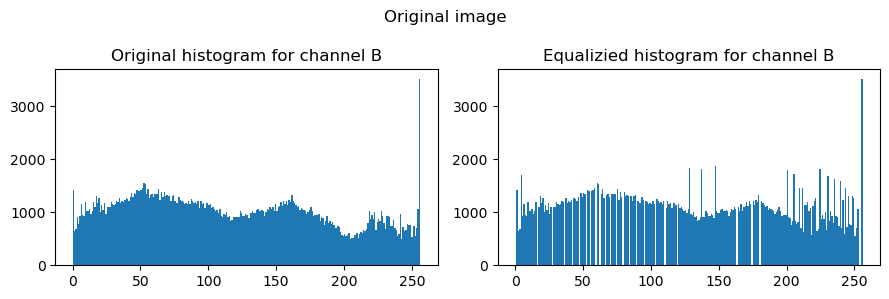

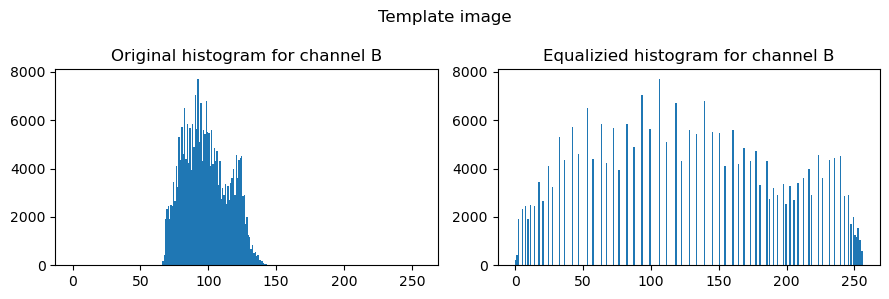

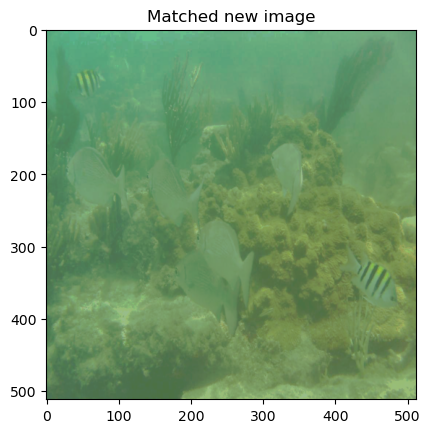

In [18]:
org_noisy_1 = np.copy(org)

channels = ["R", "G", "B"]
print(f"\033[91mMatching org.png with noisy_1.jpg:\033[0m")
print("Matching each channel separately.")
for i  in range(org.shape[-1]):
    print(f"\033[93m{channels[i]} Channel:\033[0m")
    org_noisy_1[:, :, i] = hist_matchings(org[:, :, i], noisy_1[:, :, i], channels[i])
 
plt.title('Matched new image')
plt.imshow(org_noisy_1)
plt.show()

Matching org.png with noisy_2.jpg:
Matching each channel separately.
R Channel:
Equalizing channel R


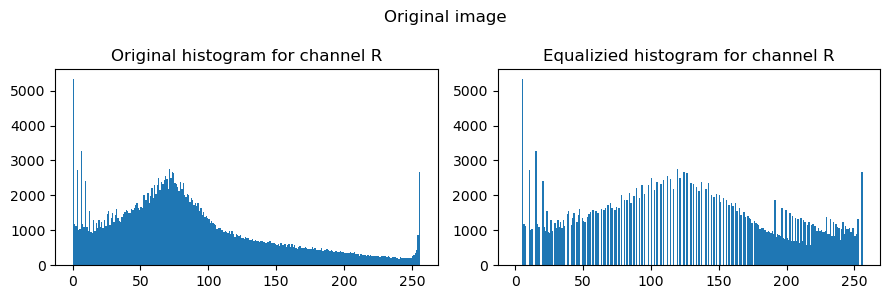

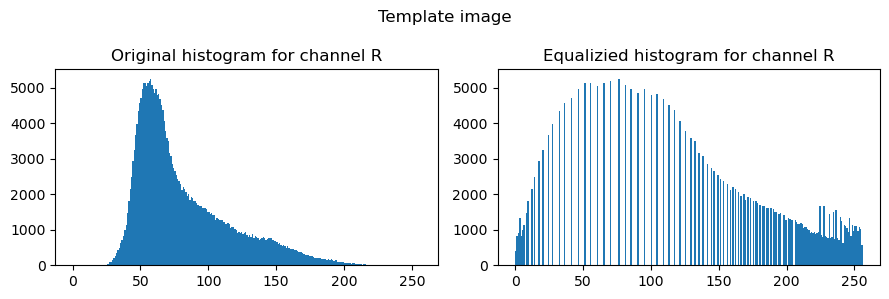

G Channel:
Equalizing channel G


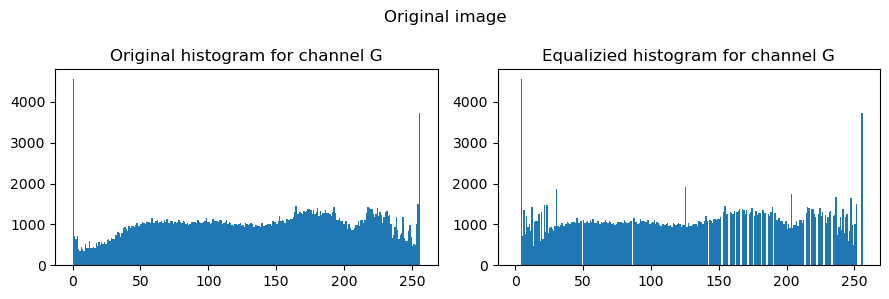

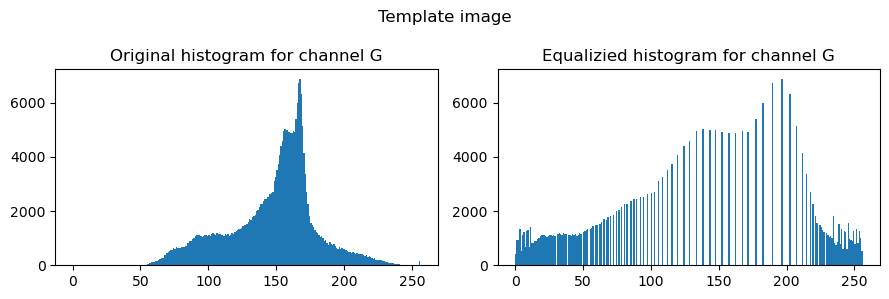

B Channel:
Equalizing channel B


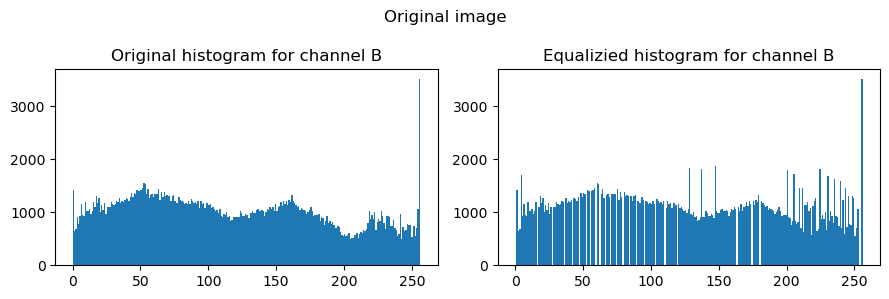

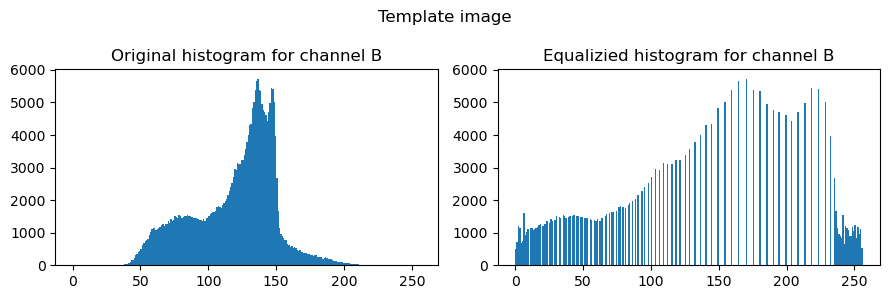

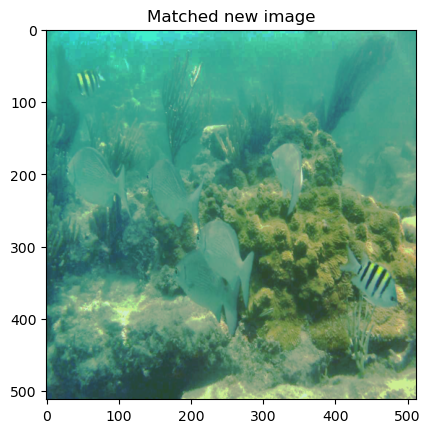

In [19]:
org_noisy_2 = np.copy(org)

channels = ["R", "G", "B"]
print(f"\033[91mMatching org.png with noisy_2.jpg:\033[0m")
print("Matching each channel separately.")
for i  in range(org.shape[-1]):
    print(f"\033[93m{channels[i]} Channel:\033[0m")
    org_noisy_2[:, :, i] = hist_matchings(org[:, :, i], noisy_2[:, :, i], channels[i])

plt.title('Matched new image')
plt.imshow(org_noisy_2)
plt.show()

<h4>Min-max stretching</h4>


$$ e^{i \pi} + 1 = 0 $$

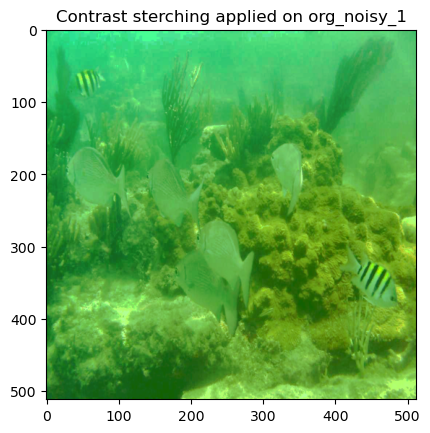

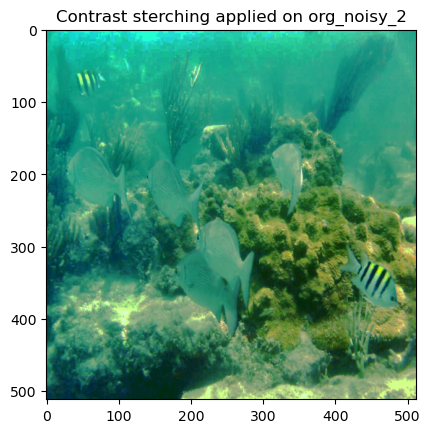

In [20]:
def stretch(image, minimum, maximum):
    image = (image - minimum) / (maximum - minimum)
    image[image < 0] = 0
    image[image > 1] = 1
    return image

mm = stretch(org_noisy_1.ravel(), np.min(org_noisy_1), np.max(org_noisy_1))
plt.title('Contrast sterching applied on org_noisy_1')
plt.imshow(mm.reshape(512, 512, 3))
plt.show()

mm = stretch(org_noisy_2.ravel(), np.min(org_noisy_2), np.max(org_noisy_2))
plt.title('Contrast sterching applied on org_noisy_2')
plt.imshow(mm.reshape(512, 512, 3))
plt.show()

<h4>Histogram Equalization</h4>

In [47]:
def apply_hist_equalization(img):
    img_eq = np.zeros_like(img)
    for i in range(org.shape[-1]):
        im = img[:, :, i]
        bins, counts = histogram(im)
        cdf = cumsum(counts, normalize=True)
        # hu = np.round(cdf * 255).astype(int)
        hu = np.round(((cdf - min(cdf))/(1 - min(cdf))) * 255).astype(int)
    
        eq_img, equalized_hist = equalize_hist(im, counts, hu, bins, "Title", channels[i])
        img_eq[:, :, i] = eq_img.reshape(512, 512)

    plt.title('Contrast sterching applied on org_noisy_1')
    plt.imshow(img_eq, cmap="gray")
    plt.show()

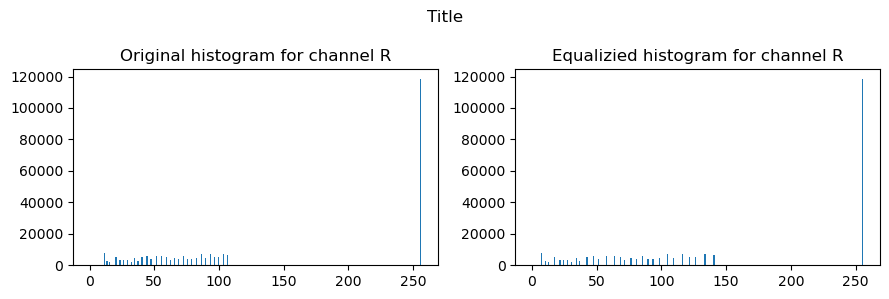

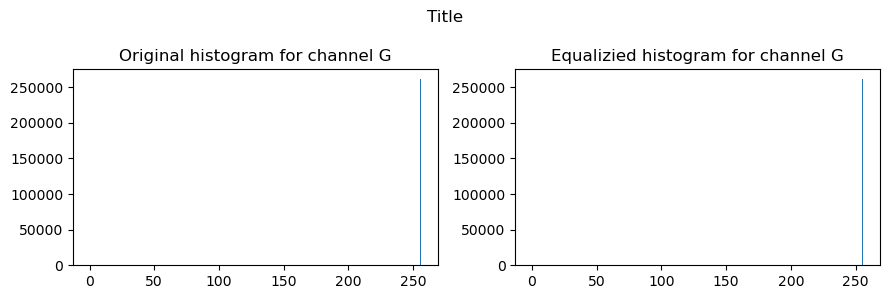

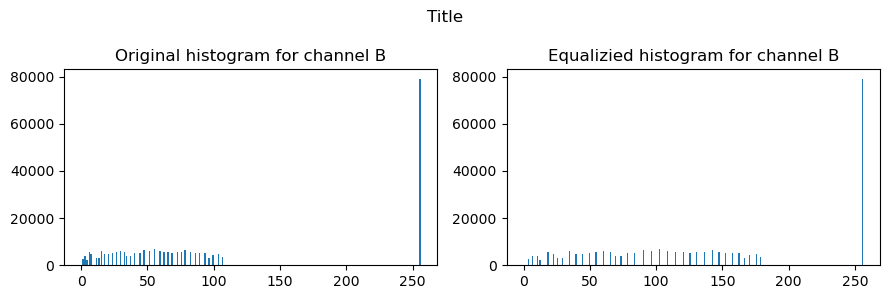

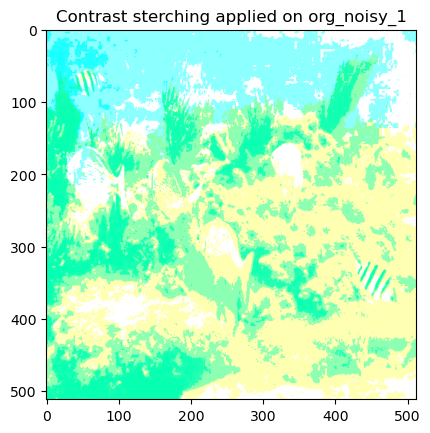

In [48]:
apply_hist_equalization(org_noisy_1)

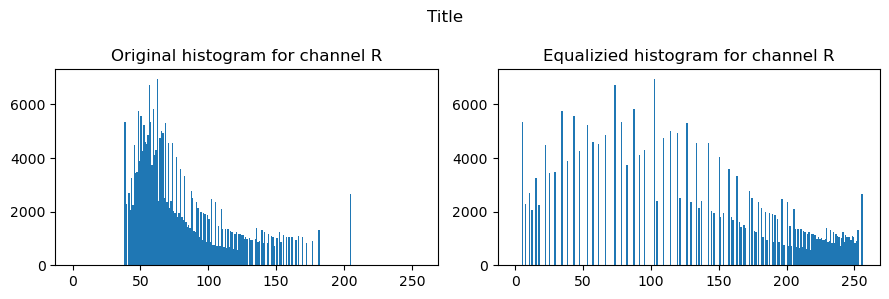

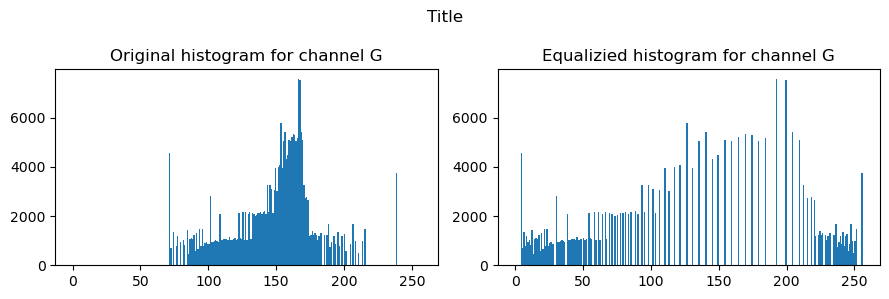

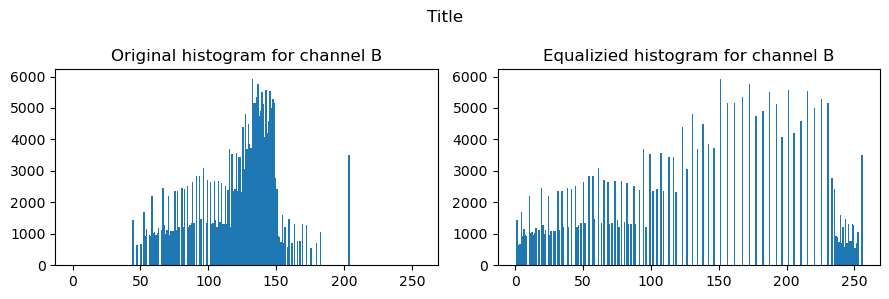

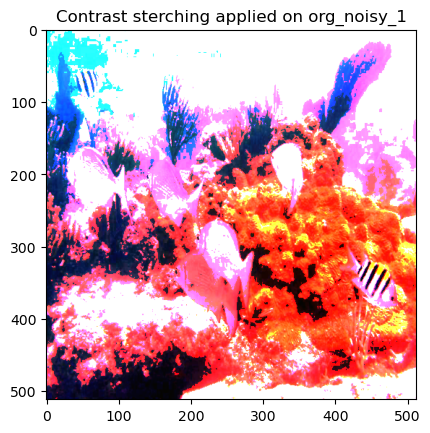

In [42]:
apply_hist_equalization(org_noisy_2)

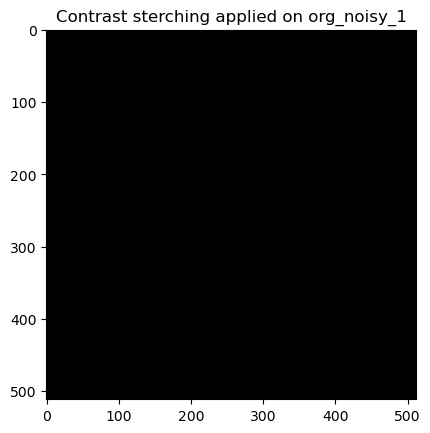

In [74]:
from skimage import exposure
org_noisy_1 = np.zeros_like(org)
for i in range(org.shape[-1]):
    org_noisy_1[:, :, i] = exposure.match_histograms(org[:, :, i], noisy_1[:, :, i])

img_eq = np.zeros_like(org_noisy_1)
for i in range(org.shape[-1]):
    img_eq[:, :, i] = exposure.equalize_hist(org_noisy_1[:, :, i])
# xxx = exposure.equalize_hist(org_noisy_2)

plt.title('Contrast sterching applied on org_noisy_1')
plt.imshow(img_eq)
plt.show()